In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
import matplotlib as mpl
from glob import glob
import scipy.integrate as integrate

%matplotlib inline

## Define your input spectrum energy and flux arrays (Energy in $GeV$ and flux is $E^{2} \Phi$ in $GeV cm^{-2} s^{-1} sr^{-1}$ ) ##

In [136]:
File = np.genfromtxt('/data/user/isafa/ahlers2010.csv', delimiter = ',')

gzk_en = File[0]
gzk_flux = File[1]

gzk_min = gzk_en[0]
gzk_max = gzk_en[-1]

## Spline the flux ##

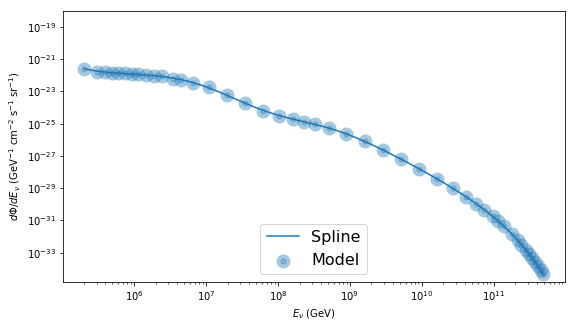

In [138]:
gzk_spline = UnivariateSpline(np.log10(gzk_en), np.log10(gzk_flux/gzk_en**2), k = 4, s=1e-2)

fig, ax = plt.subplots(figsize = (9,5))
test_log_ens = np.linspace(np.log10(gzk_min), np.log10(gzk_max+0.3), 500)


plt.scatter(gzk_en, gzk_flux/gzk_en**2, lw = 8., alpha = 0.4, label = 'Model')
plt.plot(np.power(10, test_log_ens), np.power(10., gzk_spline(test_log_ens)), label = 'Spline')
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'$E_{\nu}$ (GeV)')
plt.ylabel(r'$d\Phi / dE_{\nu}$ (GeV$^{-1}$ cm$^{-2}$ s$^{-1}$ sr$^{-1}$)')
plt.xlim(gzk_min/2., gzk_max*2.)
plt.ylim(gzk_flux.min()/gzk_max**2/3., 2.*gzk_flux.max()/gzk_min**2)
plt.legend(loc=8, fontsize = 16)
fig.set_facecolor('w')

plt.show()

## Define the probability function ##

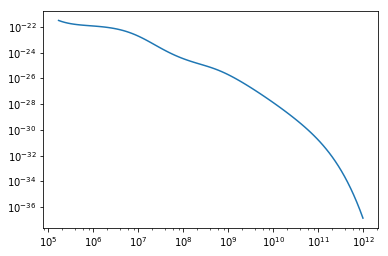

In [139]:
def integrand(energy):
    return (10**gzk_spline(np.log10(energy))) #/ energy**2

plt.plot((np.logspace(np.log10(gzk_min/1.2), np.log10(gzk_max*2.), 100)), integrand(np.logspace(np.log10(gzk_min/1.2), np.log10(gzk_max*2.), 100)))
plt.loglog()
plt.show()

In [140]:
integral = integrate.quad(lambda x: np.exp(x)*integrand(np.exp(x)), np.log(gzk_min), np.log(gzk_max))[0]

def probability(energy):
    return integrand(energy) / integral

## This should integrate to 1-ish ##

In [141]:
integ = integrate.quad(lambda x: np.exp(x)*probability(np.exp(x)), np.log(gzk_min), np.log(gzk_max))[0]

In [142]:
integ

1.0000001861236067

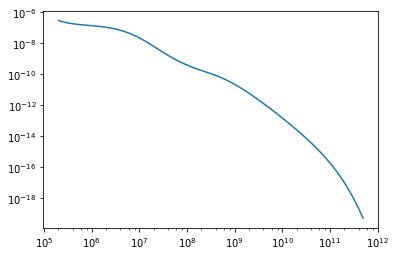

In [143]:
plt.plot(np.logspace(np.log10(gzk_min), np.log10(gzk_max), 100), probability(np.logspace(np.log10(gzk_min), np.log10(gzk_max), 100)))
plt.loglog()
plt.show()

## Make cdf ##

In [144]:
cdf_energies = np.logspace(np.log10(gzk_min), np.log10(gzk_max*1.1), 500)
cdf = np.array([integrate.quad(lambda x: np.exp(x)*probability(np.exp(x)), np.log(gzk_min), np.log(y))[0] for y in cdf_energies])
cdf = np.where(cdf < 0., 0., cdf)
cdf = np.where(cdf > 1., 1., cdf)
left = np.min(np.where(cdf != 0.)) - 1
right = np.max(np.where(cdf != 1.)) + 2
cdf = cdf[left:right]
cdf_energies = cdf_energies[left:right]


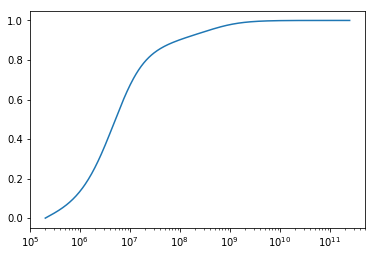

In [145]:
plt.plot(cdf_energies, cdf)
plt.xscale('log')
plt.show()

(0, 1)

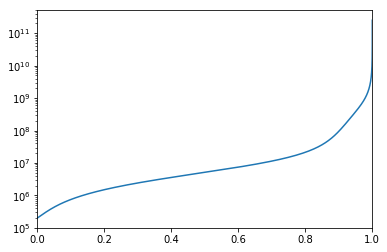

In [146]:
plt.plot(cdf, cdf_energies)
plt.yscale('log')
plt.xlim(0,1)

## Spline cdf ##

In [147]:
cdf_spline = UnivariateSpline(cdf, cdf_energies)

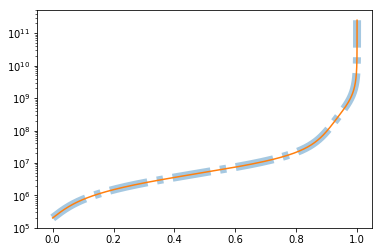

In [148]:
test_cdf_x = np.linspace(0., 1., 5000)

plt.plot(test_cdf_x, cdf_spline(test_cdf_x), lw = 8., alpha = 0.4, ls = '-.')
plt.plot(cdf, cdf_energies, ls = '-')

plt.yscale('log')


## Make sure you can sample from it and nothing looks weird. (shape of spline should match the bins) ##

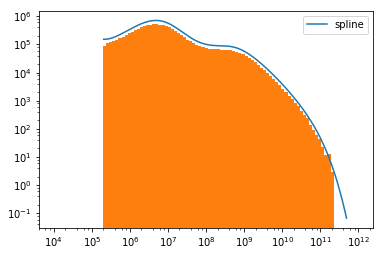

In [151]:
nsamples=10000000
random_vals = np.random.uniform(low = 0., high = 1., size=nsamples)
injected_es = cdf_spline(random_vals)

plt.plot(np.power(10, test_log_ens), 3e14*nsamples*np.power(10, test_log_ens)*np.power(10., gzk_spline(test_log_ens)), label = 'spline')

h = plt.hist(injected_es, bins = np.logspace(4., 12., 100))

plt.semilogx()
plt.semilogy(nonposy='clip')
plt.legend()
plt.show()


In [168]:
np.save('gzk_cdf_phi_spline.npy', cdf_spline)